# Задание к занятию «Элементарные алгоритмы обработки временных рядов»

Описание задания:

Взять с сайта ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения в почему была выбрана та или иная модель. (задание оформить в jupyter-notebook)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [3]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)
        
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result



## Ряд weekly-sales-of-a-cutting-tool

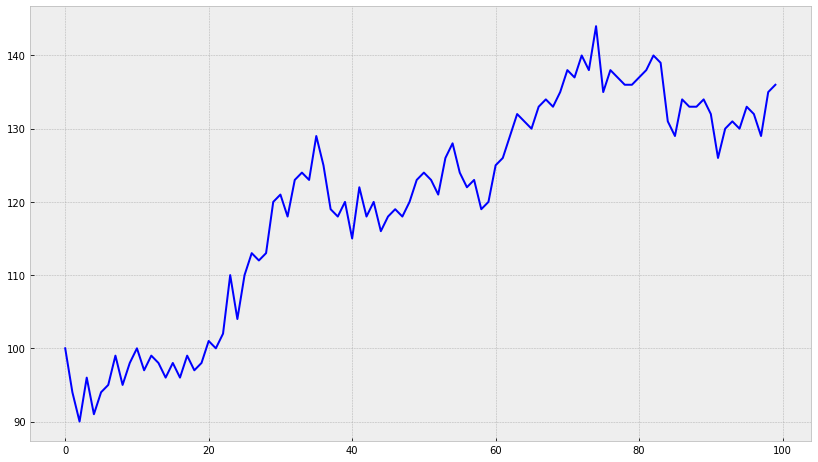

In [4]:
series = pd.read_csv('weekly-sales-of-a-cutting-tool-p.csv').iloc[:, -1]
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')

Ряд нестационарный, с ярковыраженным трендом, без сезонности.  

Двойный диффенцированием можно сделать стационарным, но попробуем приблизить разными моделями, как есть.

Предполагаем, что TEMA будет не очень подходящей моделью для приближения этого TS. Убедимся в этом ниже

### MA

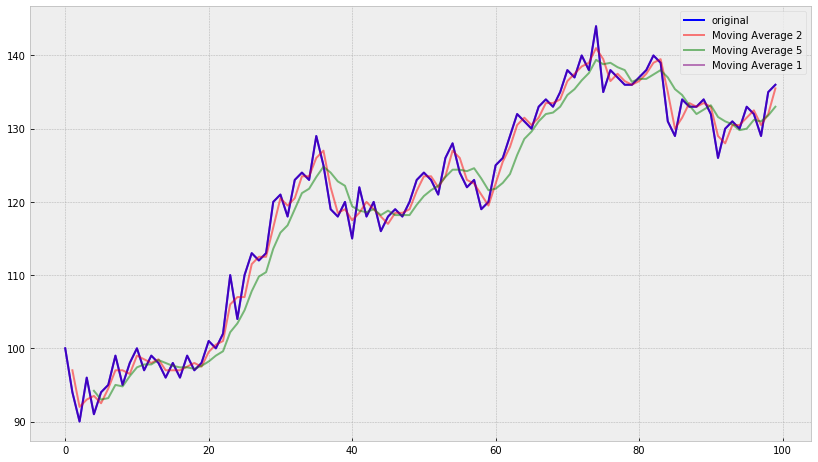

In [5]:
windows = [2,5,1]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='Moving Average {}'.format(windows[i]))
    plt.legend()

Скользящее среднее при подборе размера окна может достаточно качественно приблизить или сгладить ряд. Но, во всех случаях наблюдается явное запаздывание за изменениями ряда

### WMA

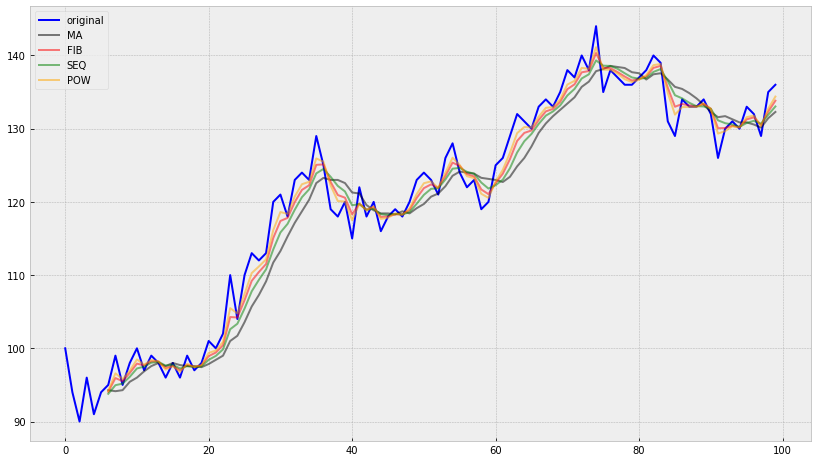

In [6]:
ma = moving_average(series, 7)
wma_fib = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series, 7, [1,2,4,8,16,32,64])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='black', linewidth='2', label='MA', alpha=0.5)
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB', alpha=0.5)
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ', alpha=0.5)
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW', alpha=0.5)
    plt.legend()

На одном и том же размере окна взвешенное скользящее среднее лучше приближает ряд, чем обычный MA

### EMA

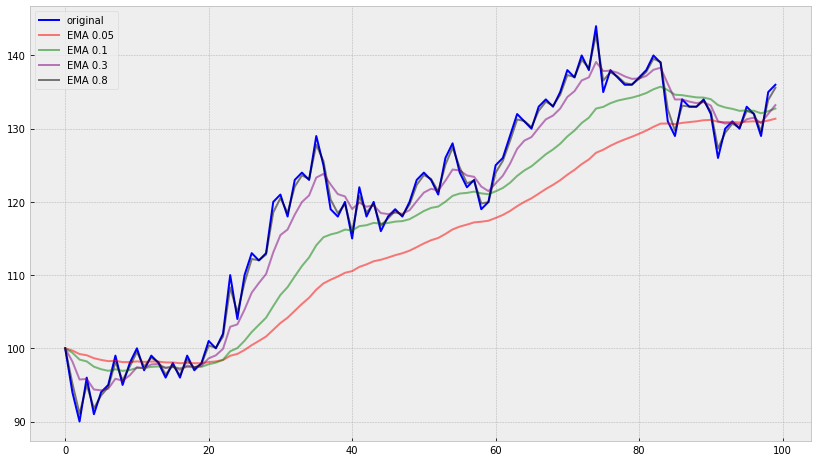

In [7]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='EMA {}'.format(alphas[i]))
    plt.legend()

Экспоненциальное сглаживание при болшом значении сглаживающего фактора может достаточно качественно приблизить исходный ряд, лучше, чем MA и WMA

### DEMA

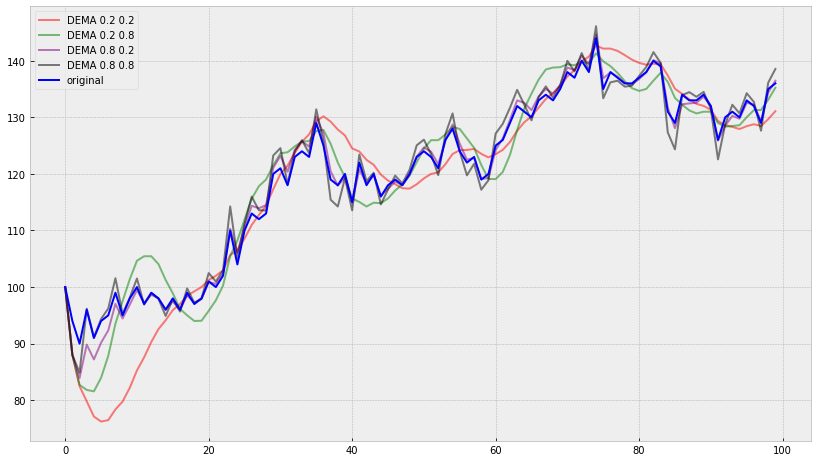

In [8]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser = double_ema(series, alphas[i], bettas[i])
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

В двойном экпоненциальном сглаживании уже налицо проблема с ручным подбором параметров. На примере выше совсем не очевидно превосходство над EMA.

### TEMA

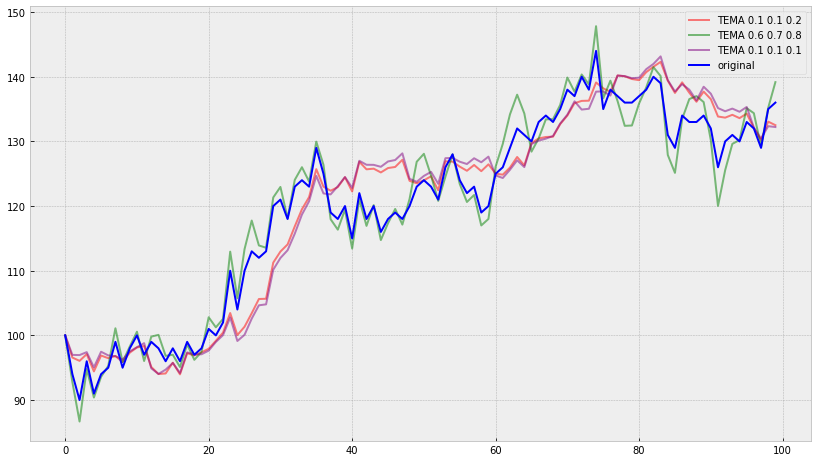

In [9]:
alphas = [0.1,0.6,0.1]
bettas = [0.1,0.7,0.1]
gammas = [0.2,0.8,0.1]
colors = ['red', 'green', 'purple', 'black']

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser = triple_exponential_smoothing(series, 12, alphas[i], bettas[i], gammas[i],  0)
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='TEMA {} {} {}'.format(alphas[i], bettas[i], gammas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

Как и предполагалось, тройное экспоненциальное сглаживание совсем не подходит для данного ряда, потому что пытается отыскать сезонность там, где ее нет. Проверим, сможем ли подобрать оптимальные параметры для приближения и обобщения.

### Подбор параметров TEMA на кроссвалидации

In [10]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [11]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA', alpha=0.5)
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [12]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

Обучаемся на первых 80 значениях ряда, предсказываем последние 20

In [13]:
train, val = series[:80], series[80:]

In [14]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [15]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.04797447601651734
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.25652830e-06,  1.23789867e-06, -3.05311332e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 240
      nit: 44
   status: 0
  success: True
        x: array([0.07336372, 0.21004961, 0.9616647 ])


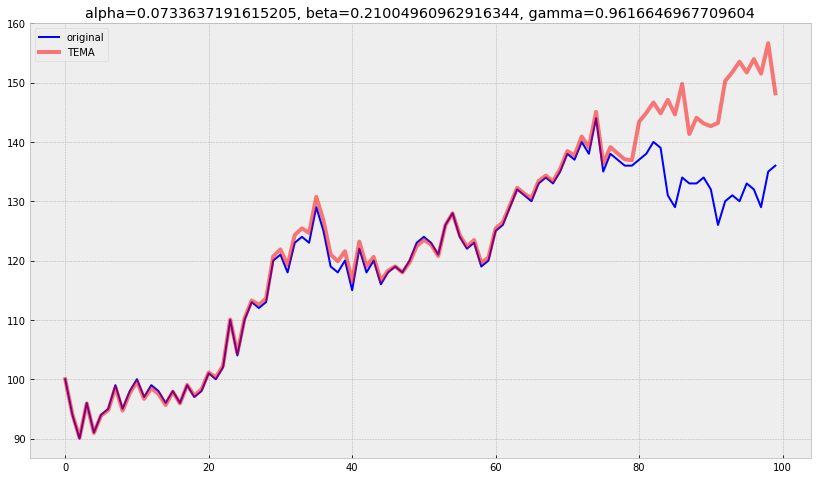

In [16]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

Модель явно переобучилась на обучающем наборе, даже обнаружила мнимую сезонность

## Ряд ozone-concentration

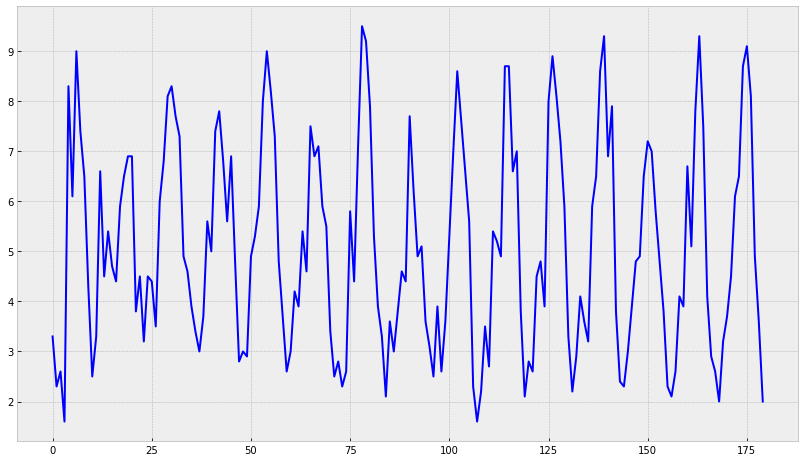

In [17]:
series = pd.read_csv('ozone-concentration-azusa-195619.csv').iloc[:, -1]
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')

Это ряд с сезонностью. Ожидаем, что тройное экпоненциальное сглаживание в лучшей степени приблизит значения ряда

### MA

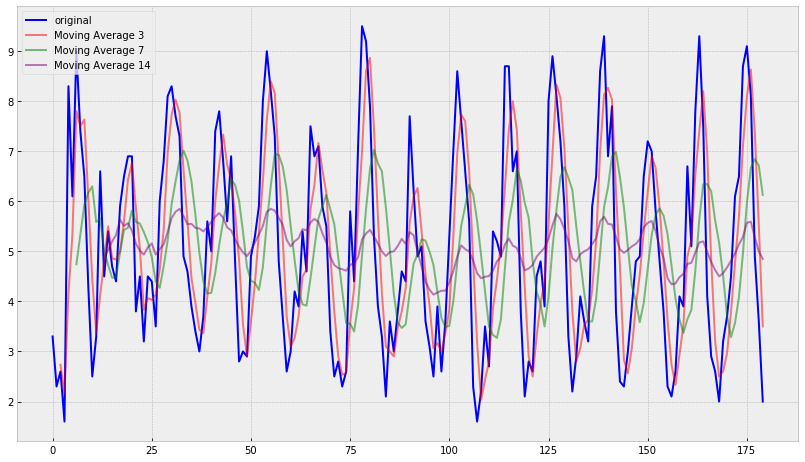

In [18]:
windows = [3,7,14]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='Moving Average {}'.format(windows[i]))
    plt.legend()

### WMA

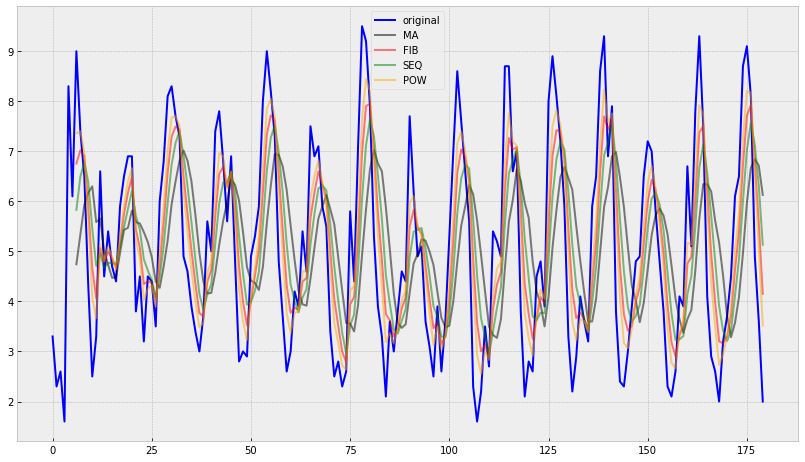

In [19]:
ma = moving_average(series, 7)
wma_fib = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series, 7, [1,2,4,8,16,32,64])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='black', linewidth='2', label='MA', alpha=0.5)
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB', alpha=0.5)
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ', alpha=0.5)
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW', alpha=0.5)
    plt.legend()

### EMA

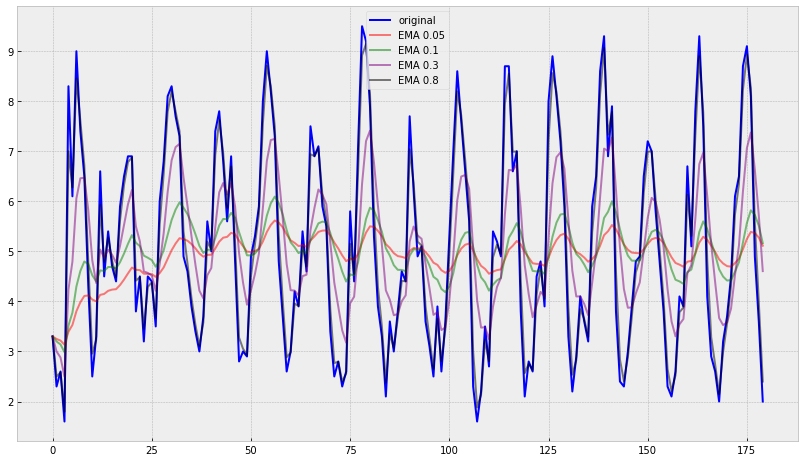

In [20]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='EMA {}'.format(alphas[i]))
    plt.legend()

### DEMA

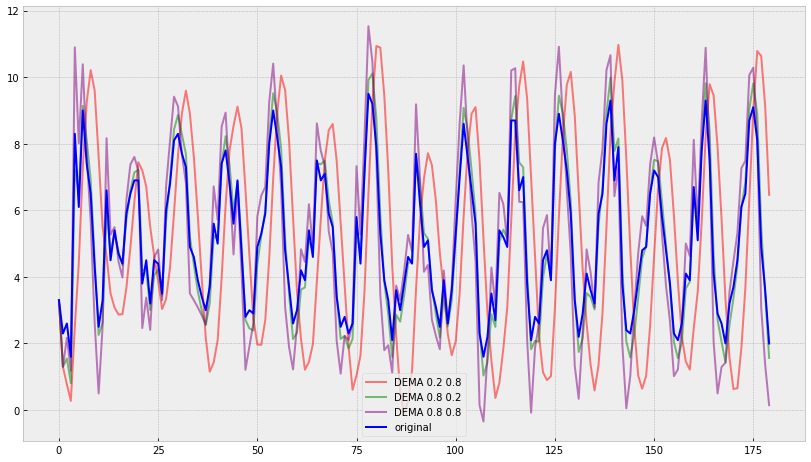

In [21]:
alphas = [0.2,0.8,0.8]
bettas = [0.8,0.2,0.8]
colors = ['red', 'green', 'purple']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser = double_ema(series, alphas[i], bettas[i])
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

### TEMA

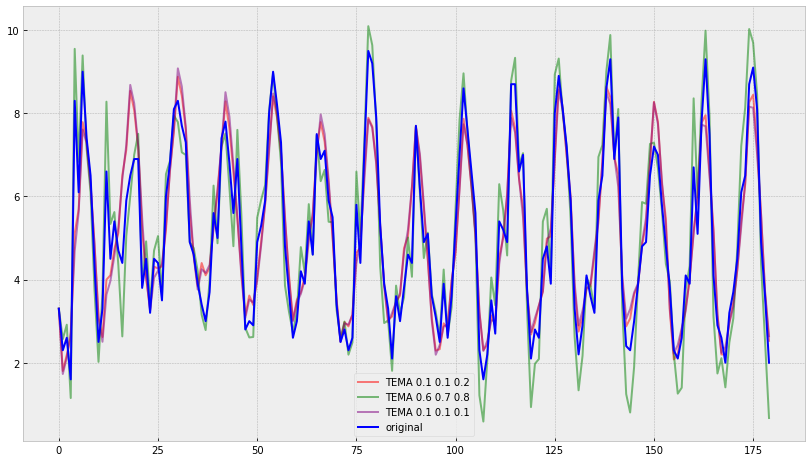

In [22]:
alphas = [0.1,0.6,0.1]
bettas = [0.1,0.7,0.1]
gammas = [0.2,0.8,0.1]
colors = ['red', 'green', 'purple', 'black']

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser = triple_exponential_smoothing(series, 12, alphas[i], bettas[i], gammas[i],  0)
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='TEMA {} {} {}'.format(alphas[i], bettas[i], gammas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

Для этого ряда тройное экспоненциальное сглаживание достаточно качественно приближает исходный ряд. Найдем на кроссвалидации оптимальные параметры

### Подбор параметров TEMA на кроссвалидации

In [23]:
train, val = series[:150], series[150:]

In [24]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [25]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 2.547017219107372e-08
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([8.52355086e-06, 2.62804439e-07, 2.94371987e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 464
      nit: 87
   status: 0
  success: True
        x: array([0.04129929, 0.26406423, 0.97321677])


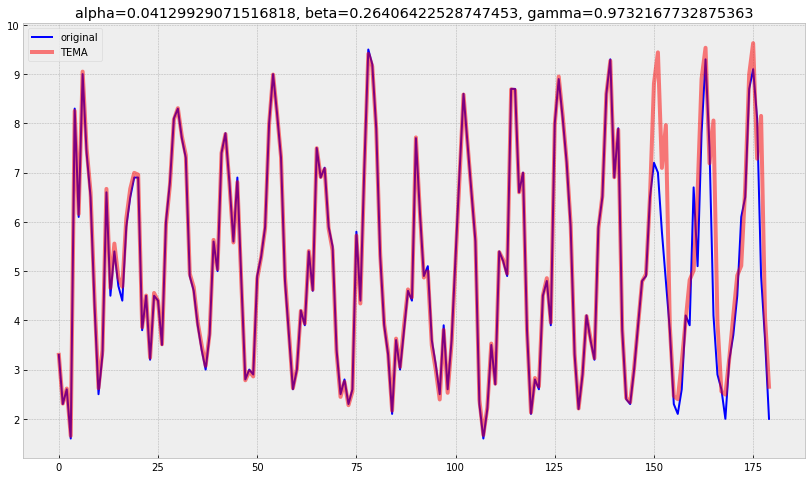

In [26]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

В целом, очень неполохой результат приближения и обобщения

## Выводы

MA, WMA подходят только для задач сглаживания с целью выявления трендов, сезонов и циклов.

EMA позволяет быстро и качественно приблизить исходный ряд, даже с ручным подбором параметров. Из минусов EMA - воможность предсказывать только одну точку ряда.

TEMA - подходит для предсказания на множество точек вперед, и не подходит для ряда без выраженной сезонности.

DEMA - параметры в ручном режиме подбирать уже сложнее, предсказательная сила только на две точки вперед, возможно, пригодится на несезонных рядах, где не работает TEMA.
